In [2]:

import platform
import sys
import pandas as pd
import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
import sklearn
import sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import log_loss,confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from operator import itemgetter
from sklearn import datasets, linear_model
import warnings
warnings.filterwarnings('ignore')
import pickle
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from pandas_profiling import ProfileReport
from sklearn.impute import IterativeImputer, SimpleImputer
from sklego.preprocessing import ColumnCapper

In [102]:
# self-defined functions

class tree_val(object):
    
    def zero_missing_unique(self, df):
        """
        Calculate missing rate, zero rate and unique value of a df
        """
        
        var_miss_rate = df.isnull().sum(axis=0)/df.shape[0]
        var_miss_rate = var_miss_rate.to_frame('missing_rate')
        
        var_zero_rate = (df==0).astype(int).sum(axis=0)/df.shape[0]
        var_zero_rate = var_zero_rate.to_frame('zero_rate')
        
        var_unique = df.nunique().to_frame('count_unique')
        var_type = df.dtypes.to_frame('data_type')
        data_stat = pd.concat([var_miss_rate, var_zero_rate, var_unique, var_type], axis=1)
        
        return data_stat
    
    def GridSearchcv_tune_model(self, model, param_grid, X_train, y_train, *args, **kwargs):
        """
        this function builds a tree based ML model using gridsearchcv with logloss as performance metric
        """
        model_gs = GridSearchCV(model, param_grid, scoring="neg_log_loss", return_train_score=True, *args, **kwargs)
        model_gs.fit(X_train, y_train)
        cv_results = pd.DataFrame(model_gs.cv_results_)
        
        return model_gs, model_gs.best_estimator_, cv_results
    
    # define partial dependency for PDPs
    def partial_dependence(self, classifier, X, y, feature_ids = [], f_id = -1):
        X_temp = X.copy()
        grid = np.linspace(np.percentile(X_temp[:, f_id], 0.1),
                           np.percentile(X_temp[:, f_id], 99.5),
                           50)
        y_pred = np.zeros(len(grid))
        for i, val in enumerate(grid):
            X_temp[:, f_id] = val
            y_pred[i] = np.average(classifier.predict_proba(X_temp)[:, 1])
            
        return grid, y_pred

In [103]:
val=tree_val()

In [32]:
# set up print options
pd.set_option('max_colwidth', 1000)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 999

In [39]:
# import training data
df_in = pd.read_csv('cs-training.csv')
df_in = df_in.drop('Unnamed: 0', axis=1)

In [40]:
df_in.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [41]:
# check and drop duplicated columns if any
print('Before dedup:', df_in.shape)
df = df_in.loc[:, ~df_in.columns.duplicated()]
print('After dedup:', df_in.shape)
duplicatedCols = df.loc[:, df.columns.duplicated()]

Before dedup: (150000, 11)
After dedup: (150000, 11)


In [42]:
# drop 'age' and 'NumberOfDependents' features from training data
drop_cols = ['age', 'NumberOfDependents']
df = df.drop(drop_cols, axis=1)
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse
0,1,0.766127,2,0.802982,9120.0,13,0,6,0
1,0,0.957151,0,0.121876,2600.0,4,0,0,0
2,0,0.658180,1,0.085113,3042.0,2,1,0,0
3,0,0.233810,0,0.036050,3300.0,5,0,0,0
4,0,0.907239,1,0.024926,63588.0,7,0,1,0


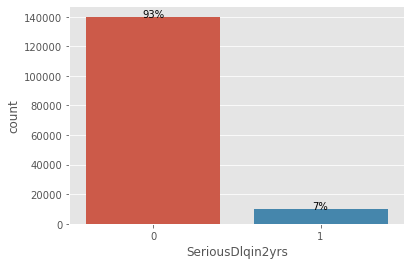

In [45]:
# plot for target variable distribution

total  = float(len(df))
ax = sns.countplot(x='SeriousDlqin2yrs', data=df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3, '{:.0%}'.format(height/total), ha='center')

In [48]:
# data partition for 80% trainin+validation vs. 20% in-time test data
x_cols = [x for x in df.columns if x!= 'SeriousDlqin2yrs']
X = df[x_cols] # features
y = df['SeriousDlqin2yrs'] # labels
# Split dataset into training set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [49]:
# check missing rate, zero rate and data type
stat_zero_missing_unique = val.zero_missing_unique(df)
stat_zero_missing_unique

,missing_rate,zero_rate,count_unique,data_type
SeriousDlqin2yrs,0.000000,0.933160,2,int64
RevolvingUtilizationOfUnsecuredLines,0.000000,0.072520,125728,float64
NumberOfTime30-59DaysPastDueNotWorse,0.000000,0.840120,16,int64
DebtRatio,0.000000,0.027420,114194,float64
MonthlyIncome,0.198207,0.010893,13594,float64
NumberOfOpenCreditLinesAndLoans,0.000000,0.012587,58,int64
NumberOfTimes90DaysLate,0.000000,0.944413,19,int64
NumberRealEstateLoansOrLines,0.000000,0.374587,28,int64
NumberOfTime60-89DaysPastDueNotWorse,0.000000,0.949307,13,int64


## random forest classifier and pipeline

In [53]:
# append random forest classifier to preprocessing pipeline
numerical_features = X_trainval.columns.to_list
numerical_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(max_iter=100,random_state=42))
        ])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features)
    ]
)

rf = RandomForestClassifier(random_state=1234)

#. now we have full prediction pipeline
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', rf)])

## load and save random forest model

In [60]:
rf_all = pickle.load(open("give_me_credit_rf.pickle", "rb"))
df_rf_gs_estimators = rf_all['rf_model']
df_rf_gs = rf_all['rf']

In [61]:
# do gridsearch
df_rf_model_results = pd.DataFrame(df_rf_gs.cv_results_)
min_idx = df_rf_model_results[['mean_test_score']].idxmax()
cv_results = df_rf_model_results.loc[pd.Index([min_idx[0]])]
print('Mean validation logloss score: {}'.format(cv_results['mean_test_score']))
print('Mean train logloss score: {}'.format(cv_results['mean_train_score']))
cv_results

Mean validation logloss score: 203   -0.179729
Name: mean_test_score, dtype: float64
Mean train logloss score: 203   -0.171305
Name: mean_train_score, dtype: float64


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
203,12.868138,0.334298,0.318569,0.010036,9,8,2,200,"{'classifier__max_depth': 9, 'classifier__min_samples_leaf': 8, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}",-0.177055,-0.178947,-0.182171,-0.181457,-0.179013,-0.179729,0.001856,1,-0.172024,-0.171389,-0.170853,-0.170955,-0.171303,-0.171305,0.000413


In [62]:
# get preprocessing X_trainval
X_trainval_preprocess = df_rf_gs_estimators.named_steps['preprocessor'].transform(X_trainval)
var_names = X_trainval.columns.tolist()
X_trainval_final = pd.DataFrame(X_trainval_preprocess, columns=var_names)

In [63]:
# preprocessing X_test
X_test_preprocess = df_rf_gs_estimators.named_steps['preprocessor'].transform(X_test)
X_test_final = pd.DataFrame(X_test_preprocess, columns=var_names)

In [64]:
# define the random forest classifier as a model
rf_model = df_rf_gs_estimators.named_steps['classifier']

# Permuation-based Feature Importance

In [65]:
from sklearn import inspection

permImpor = sklearn.inspection.permutation_importance(rf_model, X_trainval_preprocess, y_trainval,\
                                                     scoring='neg_log_loss', random_state=1234)

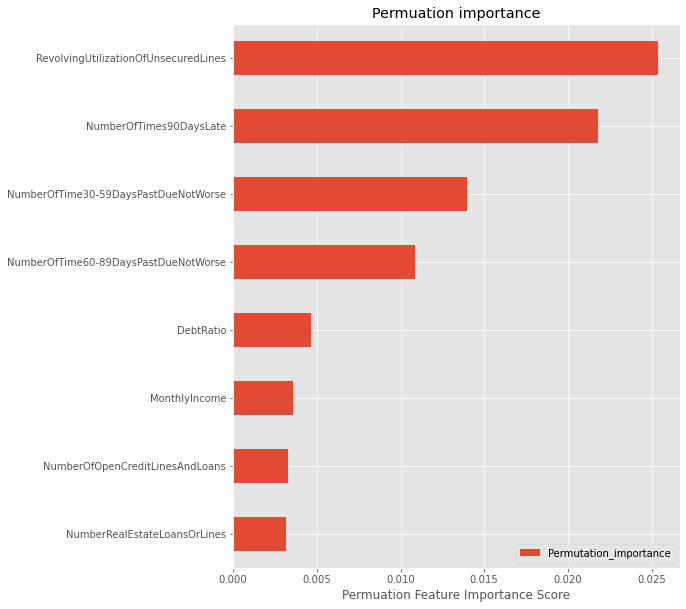

In [68]:
feats={}
for feature, importance in zip(X_trainval_final.columns, permImpor.importances_mean):
    feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0:'Permutation_importance'})
    importances = importances.sort_values(by='Permutation_importance', ascending=False)

feat_imp = importances
feat_imp.sort_values(by='Permutation_importance', inplace=True)
feat_imp.plot.barh(title="Permuation importance", figsize=(8,10))
plt.xlabel('Permuation Feature Importance Score')
plt.show()

In [72]:
feat_imp

,Permutation_importance
NumberRealEstateLoansOrLines,0.003146
NumberOfOpenCreditLinesAndLoans,0.003281
MonthlyIncome,0.003566
DebtRatio,0.004628
NumberOfTime60-89DaysPastDueNotWorse,0.010856
NumberOfTime30-59DaysPastDueNotWorse,0.013948
NumberOfTimes90DaysLate,0.021816
RevolvingUtilizationOfUnsecuredLines,0.025405


# Partial Dependence Plot (PDP)

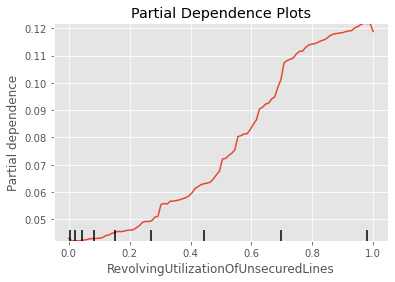

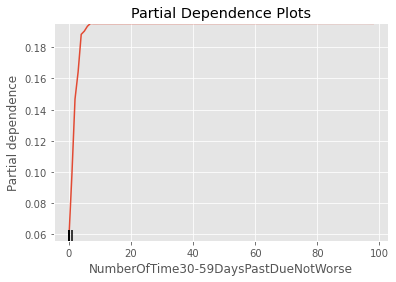

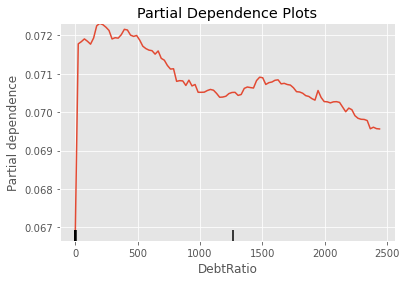

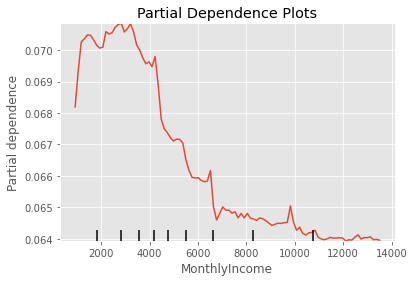

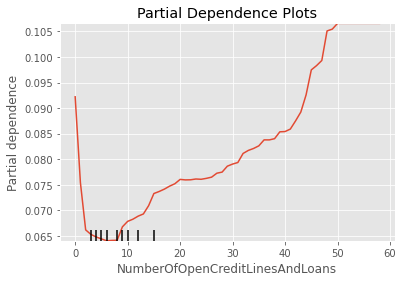

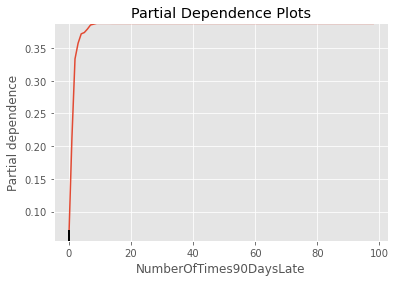

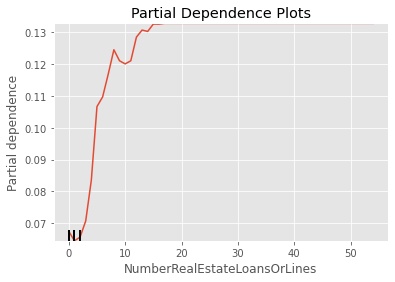

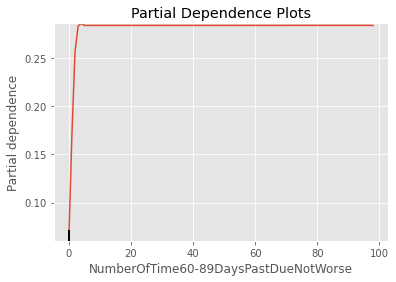

In [69]:
from sklearn.inspection import plot_partial_dependence
for i in var_names:
    fig, ax = plt.subplots()
    ax.set_title("Partial Dependence Plots")
    disp = plot_partial_dependence(rf_model, X_trainval_final, [i], ax=ax, kind='average')

# ICE Plot

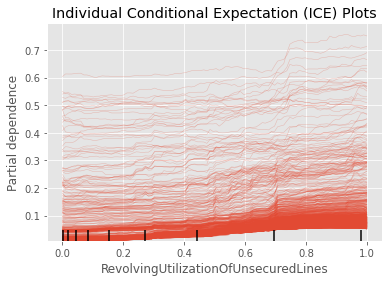

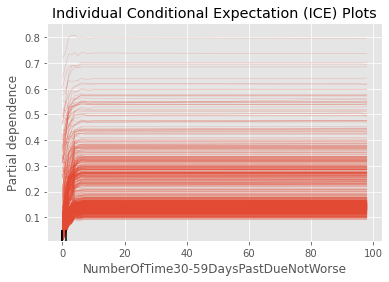

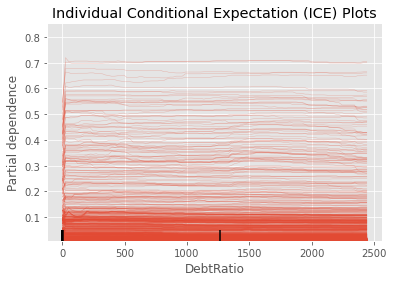

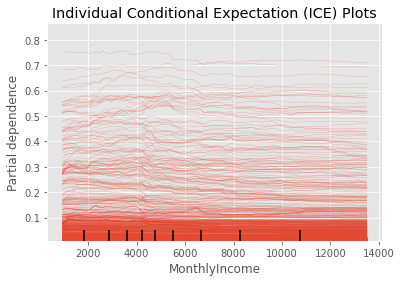

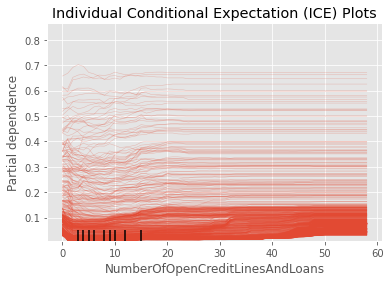

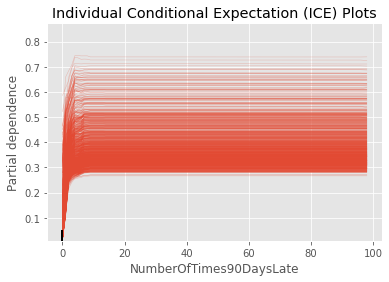

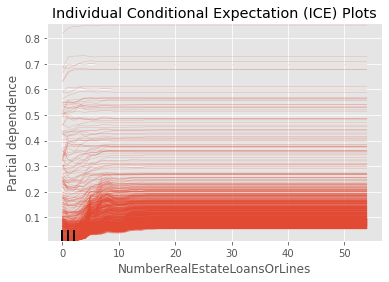

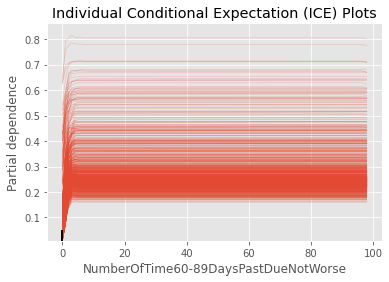

In [71]:
from sklearn.inspection import plot_partial_dependence

for i in var_names:
    fig, ax = plt.subplots()
    ax.set_title("Individual Conditional Expectation (ICE) Plots")
    disp = plot_partial_dependence(rf_model, X_trainval_final, [i], ax=ax, kind='individual')

# ALE Plot

array([[<AxesSubplot:xlabel='RevolvingUtilizationOfUnsecuredLines', ylabel='ALE'>,
        <AxesSubplot:xlabel='NumberOfTime30-59DaysPastDueNotWorse', ylabel='ALE'>],
       [<AxesSubplot:xlabel='DebtRatio', ylabel='ALE'>,
        <AxesSubplot:xlabel='MonthlyIncome', ylabel='ALE'>],
       [<AxesSubplot:xlabel='NumberOfOpenCreditLinesAndLoans', ylabel='ALE'>,
        <AxesSubplot:xlabel='NumberOfTimes90DaysLate', ylabel='ALE'>],
       [<AxesSubplot:xlabel='NumberRealEstateLoansOrLines', ylabel='ALE'>,
        <AxesSubplot:xlabel='NumberOfTime60-89DaysPastDueNotWorse', ylabel='ALE'>]],
      dtype=object)

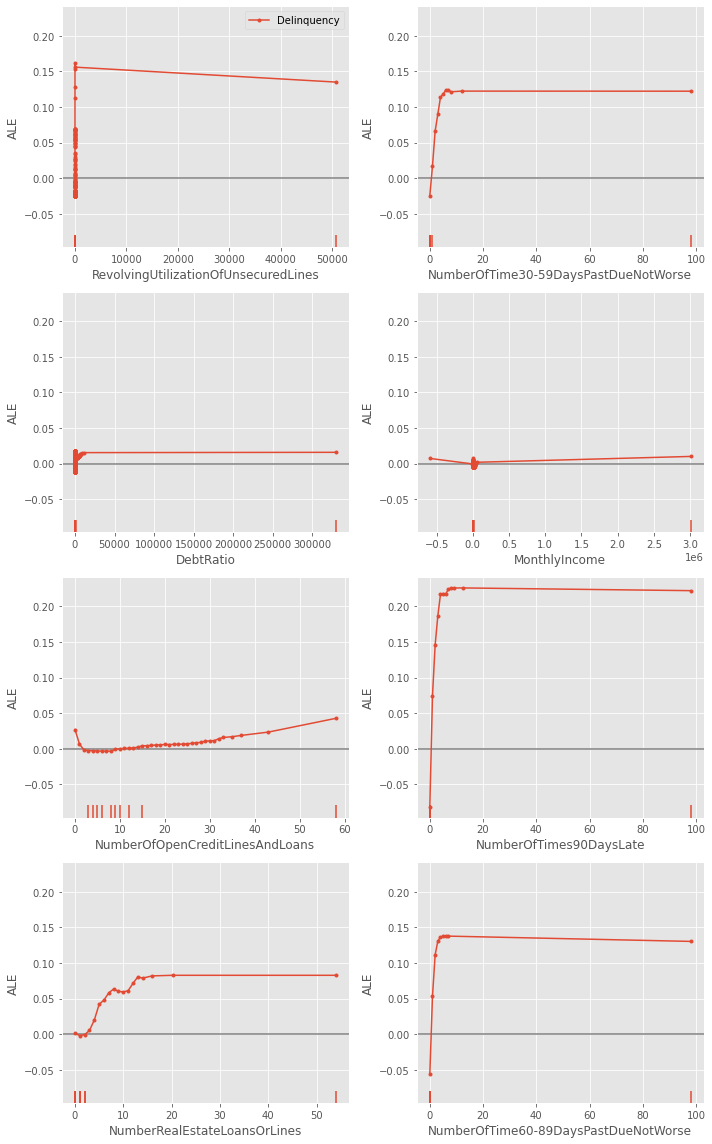

In [75]:
from alibi.explainers.ale import ALE, plot_ale
proba_fun_rf = rf_model.predict_proba
proba_ale_rf = ALE(proba_fun_rf, feature_names=var_names, target_names=["Non-delinquency","Delinquency"])
proba_exp_rf = proba_ale_rf.explain(X_trainval_preprocess)
plot_ale(proba_exp_rf, targets=["Delinquency"], n_cols=2, fig_kw={'figwidth': 10, 'figheight': 16})

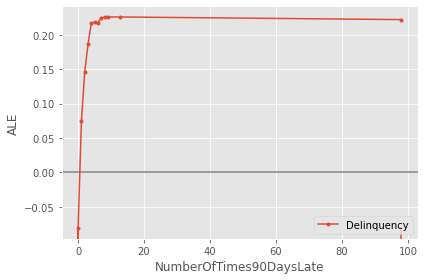

In [76]:
plot_ale(proba_exp_rf, features=["NumberOfTimes90DaysLate"], targets=["Delinquency"]);

# LIME

In [81]:
import lime # LIME package
import lime.lime_tabular

In [82]:
short_names = ['RevUtil', 'Num30-59DPD', 'DebtRatio', 'NonIncome', 'NumOpen', 'Num90DPD', 'NumREL', 'Num60-89DPD']

In [83]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_trainval_final.values, feature_names=short_names,\
                                                       class_names=['Not Delinquency','Delinquency'],\
                                                       kernel_width=None, kernel=None,\
                                                       training_labels=y_trainval.values,\
                                                       feature_selection="lasso_path",\
                                                       mode='classification', random_state=42)

# j will be the record we explain
j = 108485
exp = lime_explainer.explain_instance(X_trainval_final.iloc[j],rf_model.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=True)

In [84]:
# change the column names for SHAP local summary plots
X_trainval_shap = X_trainval_final.copy()
X_trainval_shap.columns = ['RevUtil', 'Num30-59DPD', 'DebtRatio', 'MonIncome', 'NumOpen', 'Num90DPD', 'NumRELoan','Num60-89DPD']
short_names=['RevUtil', 'Num30-59DPD', 'DebtRatio', 'NonIncome', 'NumOpen', 'Num90DPD', 'NumREL', 'Num60-89DPD']

In [85]:
%%time
# Tree explainer
import shap
# load JS visualization code to notebook
shap.initjs()
shap_explainer = shap.TreeExplainer(rf_model)
shap_values_train = shap_explainer.shap_values(X_trainval_shap)

CPU times: user 33min 42s, sys: 11.3 s, total: 33min 54s
Wall time: 34min 1s


In [87]:
# Calculate shap values for jth instance and create force plot
j=108485
shap.force_plot(base_value=shap_explainer.expected_value[1], shap_values=shap_values_train[1][j],\
               features=X_trainval_shap.iloc[j], feature_names=X_trainval_shap.columns, out_names="Delinquency")

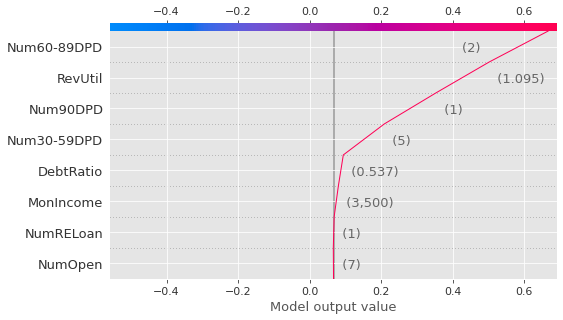

In [88]:
# decision plot
shap.decision_plot(base_value=shap_explainer.expected_value[1],shap_values=shap_values_train[1][j],\
                  features=X_trainval_shap.iloc[[j]], feature_names=X_trainval_shap.columns.tolist())

In [89]:
# calculate shap values for the jth  instance
j=100
choosen_instance = X_trainval_shap.loc[[j]]
shap_values = shap_explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(shap_explainer.expected_value[1], shap_values[1], choosen_instance, out_names="Delinquency")

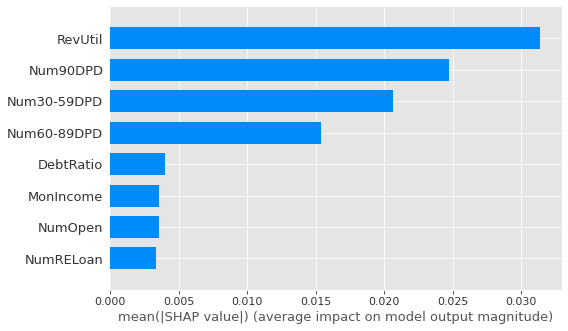

In [90]:
# Summary plot as a bar chart global interpretation SHAP feature importance
shap.summary_plot(shap_values = shap_values_train[1], features = X_trainval_shap,\
                 plot_type='bar')

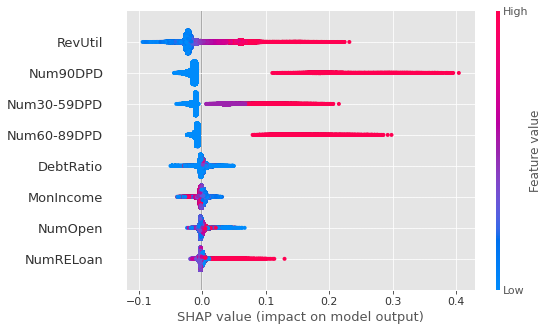

In [91]:
# Summary plot as a dot chart global interpretation
shap.summary_plot(shap_values = shap_values_train[1], features = X_trainval_shap,\
                 plot_type='dot')

In [92]:
%%time
shap_values_train_temp = shap_explainer(X_trainval_shap)

CPU times: user 33min 41s, sys: 9.93 s, total: 33min 51s
Wall time: 33min 56s


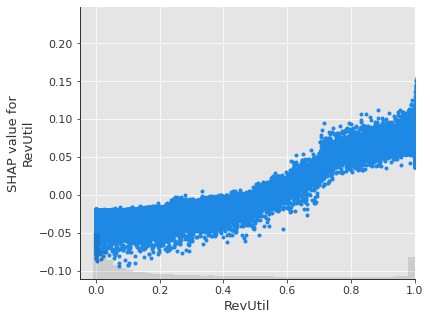

In [93]:
# shap dependence plot for RevUtil
shap.plots.scatter(shap_values_train_temp[:,"RevUtil"][:,1], xmin=0, xmax=1)

# Explainable Boosting Machined (EBM)

In [96]:
%%time 
# fit EBM model
from interpret.glassbox import ExplainableBoostingClassifier
ebm = ExplainableBoostingClassifier()
ebm.fit(X_trainval_final, y_trainval)

CPU times: user 2.43 s, sys: 910 ms, total: 3.34 s
Wall time: 19.5 s


ExplainableBoostingClassifier(feature_names=['RevolvingUtilizationOfUnsecuredLines',
                                             'NumberOfTime30-59DaysPastDueNotWorse',
                                             'DebtRatio', 'MonthlyIncome',
                                             'NumberOfOpenCreditLinesAndLoans',
                                             'NumberOfTimes90DaysLate',
                                             'NumberRealEstateLoansOrLines',
                                             'NumberOfTime60-89DaysPastDueNotWorse',
                                             'NumberOfTimes90DaysLate x '
                                             'NumberOfTime60-89DaysPastDueNotWorse',
                                             'Num...
                                             'RevolvingUtilizationOfUnsecuredLines '
                                             'x NumberRealEstateLoansOrLines',
                                             'DebtRatio x '
     

In [104]:
# show global explanation for all features
from interpret import show
ebm_global = ebm.explain_global()
from interpret import preserve
for i in var_names:
    preserve(ebm_global,i)

ContextualVersionConflict: (Jinja2 2.11.3 (/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages), Requirement.parse('Jinja2>=3.0'), {'flask'})

In [105]:
# show local explanation for j
from interpret import preserve
j=189
ebm_local = ebm.explain_local(X_trainval_final, y_trainval, name='EBM')
preserve(ebm_local, j)

ContextualVersionConflict: (Jinja2 2.11.3 (/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages), Requirement.parse('Jinja2>=3.0'), {'flask'})

# without Monotonic Constraints

In [106]:
import xgboost
xgb = xgboost.XGBClassifier(seed=1234) #, monotone_constraints='(1,1,1,-1,1,1,1,1)')

# Now we have a full prediction pipeline
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', xgb)])

# Method of selecting sample for training each tree

df_xgb_param_pipe = {
}

df_xgb_gs, df_xgb_gs_estimators, df_xgb_results = val.GridSearchcv_tune_model(pipeline_xgb, df_xgb_param_pipe,\
                                                                             X_trainval, y_trainval, cv=5, verbose=10)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START ............................................................
[CV 1/5; 1/1] END .............., score=(train=nan, test=nan) total time=   0.0s
[CV 2/5; 1/1] START ............................................................
[CV 2/5; 1/1] END .............., score=(train=nan, test=nan) total time=   0.0s
[CV 3/5; 1/1] START ............................................................
[CV 3/5; 1/1] END .............., score=(train=nan, test=nan) total time=   0.0s
[CV 4/5; 1/1] START ............................................................
[CV 4/5; 1/1] END .............., score=(train=nan, test=nan) total time=   0.0s
[CV 5/5; 1/1] START ............................................................
[CV 5/5; 1/1] END .............., score=(train=nan, test=nan) total time=   0.0s


TypeError: tolist() takes 1 positional argument but 2 were given

In [107]:
print('Mean validation logloss score: {}'.format(df_xgb_results['mean_test_score']))
print('Mean train logloss score: {}'.format(df_xgb_results['mean_train_score']))
df_xgb_results

NameError: name 'df_xgb_results' is not defined

In [ ]:
# in-time-test logloss for xgb model w/o constraints
in_time_test = pd.concat([X_test, y_test], axis=1)
in_time_test['pred_prob'] = df_xgb_gs.predict_proba(X_test)[:,1]
logloss_intime = log_loss(in_time_test['SeriousDlquin2yrs'], in_time_test['pred_proba'])
logloss_intime

# with Monotonic Constraints

In [ ]:
import xgboost
xgb_mono = xgboost.XGBClassifier(seed=1234, monotone_constraints='(1,1,1,-1,1,1,1,1)')

# Now we have a full prediction pipeline
pipeline_xgb_mono = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', xgb_mono)])

# Method of selecting sample for training each tree

df_xgb_param_pipe = {
}

df_xgb_gs_mono, df_xgb_gs_estimators_mono, df_xgb_results_mono = val.GridSearchcv_tune_model(pipeline_xgb_mono, df_xgb_param_pipe,\
                                                                             X_trainval, y_trainval, cv=5, verbose=10)

In [ ]:
print('Mean validation logloss score: {}'.format(df_xgb_results_mono['mean_test_score']))
print('Mean train logloss score: {}'.format(df_xgb_results_mono['mean_train_score']))
df_xgb_results_mono

In [ ]:
# in-time-test logloss for xgb model w/ constraints
in_time_test = pd.concat([X_test, y_test], axis=1)
in_time_test['pred_prob'] = df_xgb_gs_mono.predict_proba(X_test)[:,1]
logloss_intime = log_loss(in_time_test['SeriousDlquin2yrs'], in_time_test['pred_proba'])
logloss_intime

In [ ]:
# define the models xgb_model with and w/0 monotonic constraints
xgb_model_mono = df_xgb_gs_estimators_mono.named_steps['classifier']
xgb_model = df_xgb_gs_estimators.named_steps['classifier']

# PDP w/o Monotonic Constraints

In [ ]:
for f in var_names:
    f_id = X_train_final.columns.tolist().index(f)
    print(f_id)
    feature_ids = range(X_trainval_final.shape[1])
    print(feature_ids)
    grid, y_pred = val.partial_dependence(classifier=xgb_model, X=X_trainval_preprocess, y=y_trainval.values,\
                                         feature_ids=feature_ids=f_id)
    fig,ax = plt.subplots()
    fig.set_size_inches(6,6)
    plt.subplots_adjust(left=0.17, right=0.94, bottom=0.15, top=0.9)
    ax.plot(grid, y_pred, '-', color='blue', linewidth=2.5, label='fit')
    ax.plot(X_trainval_final.values[:, f_id], y_trainval.values, 'o', color='grey', alpha=0.01)
    ax.set_xlim(min(grid), max(grid))
    ax.set_ylim(0.95 * min(y_pred), 1.05 * max(y_pred))
    ax.set_xlabel(f, fontsize=12)
    ax.set_ylabel('Partial Dependence w/o Monotonic Constraints', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

# PDP with Monotonic Constraints

In [ ]:
for f in var_names:
    f_id = X_train_final.columns.tolist().index(f)
    print(f_id)
    feature_ids = range(X_trainval_final.shape[1])
    print(feature_ids)
    grid, y_pred = val.partial_dependence(classifier=xgb_model_mono, X=X_trainval_preprocess, y=y_trainval.values,\
                                         feature_ids=feature_ids=f_id)
    fig,ax = plt.subplots()
    fig.set_size_inches(6,6)
    plt.subplots_adjust(left=0.17, right=0.94, bottom=0.15, top=0.9)
    ax.plot(grid, y_pred, '-', color='blue', linewidth=2.5, label='fit')
    ax.plot(X_trainval_final.values[:, f_id], y_trainval.values, 'o', color='grey', alpha=0.01)
    ax.set_xlim(min(grid), max(grid))
    ax.set_ylim(0.95 * min(y_pred), 1.05 * max(y_pred))
    ax.set_xlabel(f, fontsize=12)
    ax.set_ylabel('Partial Dependence with Monotonic Constraints', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()